In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy
#from scipy.sparse import diags
#from matplotlib.animation import FuncAnimation

#plt.rcParams['figure.figsize'] = [17, 21]
#np.set_printoptions(threshold=sys.maxsize)

In [51]:
# Constants (units)
gamma = 5./3. #1.4
k_b = 1.380649e-16 # erg K^{-1}, https://en.wikipedia.org/wiki/Boltzmann_constant
a = 7.5657e-15 # erg cm^{-3} K^{-4}, radiation constant (or radiation density constant) https://en.wikipedia.org/wiki/Stefan–Boltzmann_constant
kappa = 0.1 # assume the constant
c = 2.998e10 # cm/s, speed of light
cv = 1.247e+8 # erg K^{-1} g^{-1} https://en.wikipedia.org/wiki/Specific_heat_capacity#Monatomic_gases

In [57]:
# Setting grids
def setup_grid():
    global ng, nx, dx, dy, dz, Ax, Ay, dV, ilo, ihi
    global rho, P, e, T
    global u, w
    
    xmin = 0.
    xmax = 1.

    ng = 2   # number of ghost cells
    nx = 100 # number of active cells
    dx = dy = (xmax - xmin)/nx
    dz = 1.
    Ax = dy*dz
    Ay = dx*dz
    dV = dx*dy*dz

    ilo = ng
    ihi = ng+nx

    rho = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    P   = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    e   = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    T   = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)

    u   = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    w   = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)

In [4]:
def fill_ICs(type):
    global nx, ng, ilo, ihi
    global rho, P, e, T
    global u, w
    
    if type == "1+1d shock": # 1+1d shock tube
        center = int(nx/2+ng)
        left = center - 10
        right = center + 10
        
        rho[ilo:ihi,ilo:ihi] = 0.125
        P[ilo:ihi,ilo:ihi] = 0.1
        
        rho[left:right,left:right] = 1.
        P[left:right,left:right] = 1.
    
    elif type == "1d shock": # 1d shock tube
        edge = int((nx+2*ng)/3)
        
        rho[ilo:ihi,ilo:ihi] = 0.125
        P[ilo:ihi,ilo:ihi] = 0.1
        
        rho[:,ilo:edge] = 1.
        P[:,ilo:edge] = 1.
    
    elif type == "1d shock_r": # 1d shock tube
        edge = int(2*(nx+2*ng)/3)
        
        rho[ilo:ihi,ilo:ihi] = 0.125
        P[ilo:ihi,ilo:ihi] = 0.1
        
        rho[:,edge:ihi] = 1.
        P[:,edge:ihi] = 1.
    
    else:
        print("unknown type")
    
    apply_BCs(rho)
    apply_BCs(P)
    apply_BCs(u)
    apply_BCs(w)
    
    e = P/(gamma-1.) #P/((gamma-1.)*rho)
    T = e/(cv*rho*dV)#(gamma-1.)*(dV*e)/k_b #(gamma-1.)*(rho*dV*e)/k_b
    
    apply_BCs(e)
    apply_BCs(T)

In [5]:
def colormaps():
    global ilo, ihi
    global rho, P, e, T
    global u, w
    
    plt.clf()
    
    plt.rcParams['figure.figsize'] = [25, 13] #7
    fig, axis = plt.subplots(2, 3)

    axis[0,0].pcolormesh(rho[ilo:ihi,ilo:ihi], cmap=plt.cm.jet, vmin=np.min(rho), vmax=np.max(rho))
    axis[0,0].set_title('Density')
    fig.colorbar(axis[0,0].pcolormesh(rho[ilo:ihi,ilo:ihi], cmap=plt.cm.jet, vmin=np.min(rho), vmax=np.max(rho)), ax=axis[0, 0])

    axis[0,1].pcolormesh(P[ilo:ihi,ilo:ihi], cmap=plt.cm.jet, vmin=np.min(P), vmax=np.max(P))
    axis[0,1].set_title('Pressure')
    fig.colorbar(axis[0,1].pcolormesh(P[ilo:ihi,ilo:ihi], cmap=plt.cm.jet, vmin=np.min(P), vmax=np.max(P)), ax=axis[0, 1])
    
    axis[0,2].pcolormesh(e[ilo:ihi,ilo:ihi]/rho[ilo:ihi,ilo:ihi], cmap=plt.cm.jet, vmin=np.min(e/rho), vmax=np.max(e/rho))
    axis[0,2].set_title('Specific Energy')
    fig.colorbar(axis[0,2].pcolormesh(e[ilo:ihi,ilo:ihi]/rho[ilo:ihi,ilo:ihi], cmap=plt.cm.jet, vmin=np.min(e/rho), vmax=np.max(e/rho)), ax=axis[0, 2])
    
    axis[1,0].pcolormesh(T[ilo:ihi,ilo:ihi], cmap=plt.cm.jet, vmin=np.min(T), vmax=np.max(T))
    axis[1,0].set_title('Temperature')
    fig.colorbar(axis[1,0].pcolormesh(T[ilo:ihi,ilo:ihi], cmap=plt.cm.jet, vmin=np.min(T), vmax=np.max(T)), ax=axis[1, 0])
    
    axis[1,1].pcolormesh(u[ilo:ihi,ilo:ihi], cmap=plt.cm.jet, vmin=np.min(u), vmax=np.max(u))
    axis[1,1].set_title('x velocity')
    fig.colorbar(axis[1,1].pcolormesh(u[ilo:ihi,ilo:ihi], cmap=plt.cm.jet, vmin=np.min(u), vmax=np.max(u)), ax=axis[1, 1])
                 
    axis[1,2].pcolormesh(w[ilo:ihi,ilo:ihi], cmap=plt.cm.jet, vmin=np.min(w), vmax=np.max(w))
    axis[1,2].set_title('y velocity')
    fig.colorbar(axis[1,2].pcolormesh(w[ilo:ihi,ilo:ihi], cmap=plt.cm.jet, vmin=np.min(w), vmax=np.max(w)), ax=axis[1, 2])
    

In [6]:
def total_plots():
    global ilo, ihi
    global rho, P, e, T
    global u, w
    
    plt.clf()
    
    center = int((ihi+ng)/2)
    
    plt.rcParams['figure.figsize'] = [21, 13] #7
    fig, axis = plt.subplots(2, 3)

    axis[0,0].plot(rho[center,ilo:ihi])
    axis[0,0].set_title('Density')

    axis[0,1].plot(P[center,ilo:ihi])
    axis[0,1].set_title('Pressure')
    
    axis[0,2].plot(e[center,ilo:ihi]/rho[center,ilo:ihi])
    axis[0,2].set_title('Specific Energy')
    
    axis[1,0].plot(T[center,ilo:ihi])
    axis[1,0].set_title('Temperature')
    
    axis[1,1].plot(u[center,ilo:ihi])
    axis[1,1].set_title('x velocity')
                 
    axis[1,2].plot(w[center,ilo:ihi])
    axis[1,2].set_title('y velocity')
    

In [7]:
def apply_BCs(apply):
    global ilo, ihi
    
    for var_array in [apply]:
        # outflow boundary condition for horizontal
        var_array[:,ilo-1] = var_array[:,ilo] #var_array[:,ihi-2]
        var_array[:,ilo-2] = var_array[:,ilo-1] #var_array[:,ihi-1]
        var_array[:,ihi] = var_array[:,ihi-1]
        var_array[:,ihi+1] = var_array[:,ihi]
        
        # periodic boundary condition for horizontal
        #var_array[:,ilo-2] = var_array[:,ihi-2] #var_array[:,ihi-1]
        #var_array[:,ilo-1] = var_array[:,ihi-1] #var_array[:,ihi-2]
        #var_array[:,ihi+1] = var_array[:,ilo]
        #var_array[:,ihi] = var_array[:,ilo+1]
        
        # reflecting boundary condition for vertical
        var_array[ilo-2,:] = var_array[ilo+1,:]
        var_array[ilo-1,:] = var_array[ilo,:]
        var_array[ihi,:] = var_array[ihi-1,:]
        var_array[ihi+1,:] = var_array[ihi-2,:]

In [8]:
def timestep():
    global nx, ng, ilo, ihi
    global u, w
    global dt, q

    du = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    dw = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    
    for k in range(ilo,ihi):
        for j in range(ilo,ihi):
            du[k,j] = u[k,j] - u[k,j-1] # or u[k,j] - u[k,j-1]?
            dw[k,j] = w[k,j] - w[k-1,j] # or w[k,j] - w[k-1,j]?
    apply_BCs(du)
    apply_BCs(dw)
            
    q = 3. #2. #1. # must be equal to the viscosity parameter
    cs = np.sqrt(np.abs(gamma*P/rho))
    C0 = 0.5
    dt_1 = dx/(cs+np.abs(u)) #1/cs*np.min(dx,dy)
    dt_2 = dy/(cs+np.abs(w)) #dx/np.abs(u)
    dt_3 = dx/(4.*q*q*np.abs(du)) #dy/np.abs(w)
    dt_4 = dy/(4.*q*q*np.abs(dw)) #np.min(dx/(4.q*q*np.abs(du)),dy/(4.q*q*np.abs(dw)))
    dt = C0*min(np.min(dt_1),np.min(dt_2),np.min(dt_3),np.min(dt_4))
    # dt = C0*np.max(dt_1**(-2.0)+dt_2**(-2.0)+dt_3**(-2.0)+dt_4**(-2.0))**(-0.5)

In [9]:
def s_update_velocity(): # Eq.(6.70)
    global dt, dx, dy, ilo, ihi
    global rho, P
    global u, w

    for k in range(ilo,ihi):
        for j in range(ilo,ihi):
            u[k,j] -= 2.*dt*(P[k,j]-P[k,j-1])/(dx*(rho[k,j]+rho[k,j-1]))
            w[k,j] -= 2.*dt*(P[k,j]-P[k-1,j])/(dy*(rho[k,j]+rho[k-1,j]))

    apply_BCs(u)
    apply_BCs(w)

In [10]:
def s_update_energy():
    global nx, dx, dy, ng, dt, ilo, ihi
    global rho, P, e, T

    e_temp = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    P_temp = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    P_half = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)

    for k in range(ilo,ihi):
        for j in range(ilo,ihi):        
            e_temp[k,j] = e[k,j] - dt*P[k,j]*((u[k,j+1]-u[k,j])/dx + (w[k+1,j]-w[k,j])/dy)
            P_temp[k,j] = e_temp[k,j]*(gamma-1.) #e_temp[k,j]*rho[k,j]*(gamma-1.)
            P_half[k,j] = 0.5*(P[k,j] + P_temp[k,j])
            e[k,j] -= dt*P_half[k,j]*((u[k,j+1]-u[k,j])/dx + (w[k+1,j]-w[k,j])/dy)

    P = e*(gamma-1.) #e*rho*(gamma-1.)
    T = e/(cv*rho*dV) #(gamma-1.)*(dV*e)/k_b #(gamma-1.)*(rho*dV*e)/k_b

    apply_BCs(e)
    apply_BCs(P)
    apply_BCs(T)

In [11]:
def s_apply_artificial_viscosity():
    global nx, ng, dx, dy, dt, ilo, ihi, q
    global rho, e
    global u, w
    global Qx, Qy

    def obtain_Q():
        global nx, ng, dt, ilo, ihi, q
        global rho, e
        global u, w
        global Qx, Qy

        Qx = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
        Qy = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)

        for k in range(ilo,ihi):
            for j in range(ilo,ihi):
                if u[k,j+1]-u[k,j] < 0.:
                    Qx[k,j] = q*q*rho[k,j]*(u[k,j+1]-u[k,j])*(u[k,j+1]-u[k,j])
                else:
                    Qx[k,j] = 0.

        for k in range(ilo,ihi):
            for j in range(ilo,ihi):
                if w[k+1,j]-w[k,j] < 0.:
                    Qy[k,j] = q*q*rho[k,j]*(w[k+1,j]-w[k,j])*(w[k+1,j]-w[k,j])
                else:
                    Qy[k,j] =  0.

        apply_BCs(Qx)
        apply_BCs(Qy)

    obtain_Q()

    for k in range(ilo,ihi):
        for j in range(ilo,ihi):
            u[k,j] -= 2.*dt*(Qx[k,j]-Qx[k,j-1])/(dx*(rho[k,j]+rho[k,j-1]))
            w[k,j] -= 2.*dt*(Qy[k,j]-Qy[k-1,j])/(dy*(rho[k,j]+rho[k-1,j]))
            
            e[k,j] -= dt*(Qx[k,j]*(u[k,j+1]-u[k,j])/dx + Qy[k,j]*(w[k+1,j]-w[k,j])/dy)

    apply_BCs(u)
    apply_BCs(w)
    apply_BCs(e)

In [12]:
def solve_source():
    global nx, ng, dx, dy, dt, ilo, ihi
    global rho, P, e, T, q
    global u, w
    global Qx, Qy

    s_update_velocity()
    s_update_energy()
    s_apply_artificial_viscosity()

In [13]:
def ad_obtain_avg(method="van Leer"):
    global ng, nx, ilo, ihi, dt
    global rho, e
    global u, w
    global avg_rho_x, avg_rho_y, avg_e_x, avg_e_y
    global avg_u_x, avg_u_y, avg_w_x, avg_w_y
    
    drho_dr_x = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    drho_dr_y = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    
    avg_rho_x = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    avg_rho_y = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    
    avg_e_x = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    avg_e_y = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    
    avg_u_x = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    avg_u_y = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    
    avg_w_x = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    avg_w_y = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    
    # velocity
    for k in range(ilo,ihi):
        for j in range(ilo,ihi):    
            if 0.5*(u[k,j]+u[k,j-1]) >= 0.: #0.5*(u[k,j]+u[k,j-1]) <= 0.:
                avg_u_x[k,j] = u[k,j-1]
                avg_w_x[k,j] = w[k,j-1]
            else:
                avg_u_x[k,j] = u[k,j]
                avg_w_x[k,j] = w[k,j]

            if 0.5*(w[k,j]+w[k-1,j]) >= 0.: #0.5*(w[k,j]+w[k-1,j]) <= 0.:
                avg_u_y[k,j] = u[k-1,j]
                avg_w_y[k,j] = w[k-1,j]
            else:
                avg_u_y[k,j] = u[k,j]
                avg_w_y[k,j] = w[k,j]
    
    
    # shifting variables
    rho_temp_x = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    rho_temp_y = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    
    e_temp_x = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    e_temp_y = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    
    for k in range(ilo,ihi):
        for j in range(ilo,ihi):
            rho_temp_x[k,j] = 0.5*(rho[k,j]+rho[k,j-1])
            rho_temp_y[k,j] = 0.5*(rho[k,j]+rho[k-1,j])
            e_temp_x[k,j] = 0.5*(e[k,j]+e[k,j-1])
            e_temp_y[k,j] = 0.5*(e[k,j]+e[k-1,j])
            
    apply_BCs(rho_temp_x)
    apply_BCs(rho_temp_y)
    apply_BCs(e_temp_x)
    apply_BCs(e_temp_y)
    
    
    if method == "donor": # use this for now
        for k in range(ilo,ihi):
            for j in range(ilo,ihi):

                if u[k,j] >= 0.: 
                    avg_rho_x[k,j] = 0.5*(rho_temp_x[k,j-1]+rho_temp_x[k,j])
                    #0.5*(rho[k,j-1]+rho[k,j])
                    avg_e_x[k,j] = 0.5*(e_temp_x[k,j-1]+e_temp_x[k,j])/avg_rho_x[k,j]
                    #0.5*(e[k,j-1]+e[k,j])/avg_rho_x[k,j]
                else: # u[k,j] < 0.:
                    avg_rho_x[k,j] = 0.5*(rho_temp_x[k,j]+rho_temp_x[k,j+1])
                    #0.5*(rho[k,j]+rho[k,j+1])
                    avg_e_x[k,j] = 0.5*(e_temp_x[k,j]+e_temp_x[k,j+1])/avg_rho_x[k,j]
                    #0.5*(e[k,j]+e[k,j+1])/avg_rho_x[k,j]
                    
                if w[k,j] >= 0.:
                    avg_rho_y[k,j] = 0.5*(rho_temp_y[k-1,j]+rho_temp_y[k,j]) 
                    #0.5*(rho[k-1,j]+rho[k,j]) 
                    avg_e_y[k,j] = 0.5*(e_temp_y[k-1,j]+e_temp_y[k,j])/avg_rho_y[k,j]
                    #0.5*(e[k-1,j]+e[k,j])/avg_rho_y[k,j]
                else:
                    avg_rho_y[k,j] = 0.5*(rho_temp_y[k,j]+rho_temp_y[k+1,j])
                    #0.5*(rho[k,j]+rho[k+1,j])
                    avg_e_y[k,j] = 0.5*(e_temp_y[k,j]+e_temp_y[k+1,j])/avg_rho_y[k,j]
                    #0.5*(e[k,j]+e[k+1,j])/avg_rho_y[k,j]

          
    elif method == "van Leer":
        
        def get_avg_x(var):
            
            avg_var_x = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
            
            for k in range(ilo,ihi):
                for j in range(ilo,ihi):
                    dq = 0.
                    dq_half_l = 0.
                    dq_half_r = 0.
                    if u[k,j] >= 0.:
                        dq_half_l = (var[k,j]-var[k,j-1])/dx
                        dq_half_r = (var[k,j-1]-var[k,j-2])/dx
                        if dq_half_l*dq_half_r > 0.:
                            dq = 2.*dq_half_l*dq_half_r/(dq_half_l+dq_half_r)
                        else:
                            dq = 0
                        avg_var_x[k,j] = var[k,j-1] + (dx - u[k,j]*dt)*(dq/2.)
                    else: #u[k,j] < 0
                        dq_half_l = (var[k,j+1]-var[k,j])/dx
                        dq_half_r = (var[k,j]-var[k,j-1])/dx
                        if dq_half_l*dq_half_r > 0.:
                            dq = 2.*dq_half_r*dq_half_l/(dq_half_r+dq_half_l)
                        else:
                            dq = 0
                        avg_var_x[k,j] = var[k,j] - (dx + u[k,j]*dt)*(dq/2.)
            return avg_var_x
        
        def get_avg_y(var):
            
            avg_var_y = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
            
            for k in range(ilo,ihi):
                for j in range(ilo,ihi):
                    dq = 0.
                    dq_half_l = 0.
                    dq_half_r = 0.
                    if w[k,j] >= 0.:
                        dq_half_l = (var[k,j]-var[k-1,j])/dy
                        dq_half_r = (var[k-1,j]-var[k-2,j])/dy
                        if dq_half_l*dq_half_r > 0.:
                            dq = 2.*dq_half_l*dq_half_r/(dq_half_l+dq_half_r)
                        else:
                            dq = 0
                        avg_var_y[k,j] = var[k-1,j] + (dy - w[k,j]*dt)*(dq/2.)
                    else: #w[k,j] < 0
                        dq_half_l = (var[k+1,j]-var[k,j])/dy
                        dq_half_r = (var[k,j]-var[k-1,j])/dy
                        if dq_half_l*dq_half_r > 0.:
                            dq = 2.*dq_half_r*dq_half_l/(dq_half_r+dq_half_l)
                        else:
                            dq = 0
                        avg_var_y[k,j] = var[k,j] - (dy + w[k,j]*dt)*(dq/2.)
            return avg_var_y

        avg_rho_x = get_avg_x(rho)
        avg_e_x = get_avg_x(e)/avg_rho_x
        
        avg_rho_y = get_avg_y(rho)
        avg_e_y = get_avg_y(e)/avg_rho_y
        
    else:
        print("Sorry, under development!")
    
    total = [avg_rho_x, avg_rho_y, avg_e_x, avg_e_y, avg_u_x, avg_u_y, avg_w_x, avg_w_y]
    for var in total:
        apply_BCs(var)

In [14]:
def ad_update_density():
    global ng, nx, Ax, Ay, dV, dt, ilo, ihi
    global rho
    global u, w
    global f_rho_x, f_rho_y
    global avg_rho_x, avg_rho_y

    
    f_rho_x = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    f_rho_y = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)    
    
    # density flux
    for k in range(ilo,ihi):
        for j in range(ilo,ihi):
            f_rho_x[k,j] = u[k,j]*avg_rho_x[k,j]*Ax
            f_rho_y[k,j] = w[k,j]*avg_rho_y[k,j]*Ay

    apply_BCs(f_rho_x)
    apply_BCs(f_rho_y)

    # density calculation
    for k in range(ilo,ihi):
        for j in range(ilo,ihi):            
            rho[k,j] -= (dt/dV)*(f_rho_x[k,j+1]-f_rho_x[k,j])
            rho[k,j] -= (dt/dV)*(f_rho_y[k+1,j]-f_rho_y[k,j])

    apply_BCs(rho)

In [15]:
def ad_update_energy():
    global ng, nx, dV, dt, ilo, ihi
    global e
    global f_rho_x, f_rho_y, f_e_x, f_e_y
    global avg_e_x, avg_e_y
    
    f_e_x = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    f_e_y = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)

    # energy flux
    for k in range(ilo,ihi):
        for j in range(ilo,ihi):            
            f_e_x[k,j] = avg_e_x[k,j]*f_rho_x[k,j]
            f_e_y[k,j] = avg_e_y[k,j]*f_rho_y[k,j]

    apply_BCs(f_e_x)
    apply_BCs(f_e_y)
    
    # energy calculation
    for k in range(ilo,ihi):
        for j in range(ilo,ihi):
            e[k,j] -= (dt/dV)*(f_e_x[k,j+1]-f_e_x[k,j])
            e[k,j] -= (dt/dV)*(f_e_y[k+1,j]-f_e_y[k,j])
    
    apply_BCs(e)
    
    P = e*(gamma-1.) #e*rho*(gamma-1.)
    T = e/(cv*rho*dV) #(gamma-1.)*(dV*e)/k_b #(gamma-1.)*(rho*dV*e)/k_b

    apply_BCs(P)
    apply_BCs(T)

In [16]:
def ad_get_momentum():
    global ng, nx, ilo, ihi
    global f_u_x, f_u_y, f_w_x, f_w_y
    global f_rho_x, f_rho_y, f_e_x, f_e_y
    
    f_u_x = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    f_u_y = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    f_w_x = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    f_w_y = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    
    for k in range(ilo,ihi):
        for j in range(ilo,ihi):
            f_u_x[k,j] = avg_u_x[k,j]*0.5*(f_rho_x[k,j-1]+f_rho_x[k,j])
            f_u_y[k,j] = avg_u_y[k,j]*0.5*(f_rho_y[k,j-1]+f_rho_y[k,j])
            f_w_x[k,j] = avg_w_x[k,j]*0.5*(f_rho_x[k-1,j]+f_rho_x[k,j])
            f_w_y[k,j] = avg_w_y[k,j]*0.5*(f_rho_y[k-1,j]+f_rho_y[k,j])

    apply_BCs(f_u_x)
    apply_BCs(f_u_y)            
    apply_BCs(f_w_x)            
    apply_BCs(f_w_y)

In [17]:
def ad_update_momentum():
    global ng, nx, dV, ilo, ihi
    global rho
    global u, w
    global mom_den_u, mom_den_w
    global f_u_x, f_u_y, f_w_x, f_w_y

    mom_den_u = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    mom_den_w = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    
    # momentum-density
    for k in range(ilo,ihi):
        for j in range(ilo,ihi):
            mom_den_u[k,j] = 0.5*(rho[k,j]+rho[k,j-1])*u[k,j]
            mom_den_w[k,j] = 0.5*(rho[k,j]+rho[k-1,j])*w[k,j]
                
    apply_BCs(mom_den_u)
    apply_BCs(mom_den_w)
    
    # momentum-density update
    for k in range(ilo,ihi):
        for j in range(ilo,ihi):            
            mom_den_u[k,j] -= (dt/dV)*(f_u_x[k,j+1]-f_u_x[k,j])
            mom_den_u[k,j] -= (dt/dV)*(f_u_y[k+1,j]-f_u_y[k,j])

            mom_den_w[k,j] -= (dt/dV)*(f_w_x[k,j+1]-f_w_x[k,j])
            mom_den_w[k,j] -= (dt/dV)*(f_w_y[k+1,j]-f_w_y[k,j])

    apply_BCs(mom_den_u)
    apply_BCs(mom_den_w)

In [18]:
def ad_update_velocity():
    global rho
    global u, w
    global mon_den_u, mon_den_w
    
    for k in range(ilo,ihi):
        for j in range(ilo,ihi):
            
            u[k,j] = mom_den_u[k,j]/(0.5*(rho[k,j]+rho[k,j-1]))
            w[k,j] = mom_den_w[k,j]/(0.5*(rho[k,j]+rho[k-1,j]))
            
    apply_BCs(u)
    apply_BCs(w)

In [19]:
def ad_update_temperature():
    global ilo, ihi, dV, cv
    global rho, e, T
    
    for k in range(ilo,ihi):
        for j in range(ilo,ihi):    
            T[k,j] = e[k,j]/(cv*rho[k,j]*dV) #(gamma-1.)*(dV*e[k,j])/k_b #(gamma-1.)*(rho[k,j]*dV*e[k,j])/k_b
    apply_BCs(T)

In [20]:
def solve_advection():
    global ng, nx, dx, dy, dz, Ax, Ay, dV, ilo, ihi, dt, q
    global rho, P, e, T
    global u, w
    global mon_den_u, mon_den_w
    global avg_rho_x, avg_rho_y, avg_e_x, avg_e_y
    global avg_u_x, avg_u_y, avg_w_x, avg_w_y
    
    ad_obtain_avg()
    ad_update_density()
    ad_update_energy()
    ad_get_momentum()
    ad_update_momentum()
    ad_update_velocity()
    ad_update_temperature()

In [21]:
def evolution_2d(tmax):
    for i in range(tmax):    
    
        timestep()
    #    print(dt)

        #solve_source()
        s_update_velocity()
        s_update_energy()
        s_apply_artificial_viscosity()

        #solve_advection()
        ad_obtain_avg()
        ad_update_density()
        ad_update_energy()
        ad_get_momentum()
        ad_update_momentum()
        ad_update_velocity()
        ad_update_temperature()
        
        #solve_radiation_transport()
        rad_transport()

        colormaps()
        plt.pause(0.1)

    
def evolution_1d(tmax):
    for i in range(tmax):    
    
        timestep()
    #    print(dt)

        #solve_source()
        s_update_velocity()
        s_update_energy()
        s_apply_artificial_viscosity()

        #solve_advection()
        ad_obtain_avg()
        ad_update_density()
        ad_update_energy()
        ad_get_momentum()
        ad_update_momentum()
        ad_update_velocity()
        ad_update_temperature()
        
        #solve_radiation_transport()
        rad_transport()

        total_plots()
        plt.pause(0.1)#total_plots()
#plt.pause(0.1)



In [22]:
def rad_obtain_R():
    global nx, ng, ilo, ihi, dy
    global T, rho
    global R, kappa
    
    R = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    
    for k in range(ilo,ihi):
        for j in range(ilo,ihi):  
            R[k,j] = 1./((T[k,j]+T[k-1,j])*(rho[k,j]+rho[k-1,j])*kappa)*(T[k,j]-T[k-1,j])/dy
            
    apply_BCs(R)
    
#rad_obtain_R()
#print(R,np.max(R), np.min(R))

In [23]:
def rad_obtain_lamda():
    global R, lamda
 
    lamda = (2. + R)/(6. + 3.*R + R*R)

#    apply_BCs(lamda)

#rad_obtain_lamda()
#print(lamda,np.max(lamda),np.min(lamda))

In [24]:
def rad_obtain_D():
    global nx, ng, ilo, ihi
    global a, c, lamda, T, rho, cv, kappa
    global D
    
    D = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)

    for k in range(ilo,ihi):
        for j in range(ilo,ihi):  
            D[k,j] = 4.*a*c*lamda[k,j]*((0.5*(T[k,j]+T[k-1,j]))**3.)/(cv*kappa*((0.5*(rho[k,j]+rho[k-1,j]))**2.)) #used averaged temperature since it's a vector term
    
    apply_BCs(D)
    
#rad_obtain_D()
#print(D[:,ilo+50],np.max(D),np.min(D))

In [25]:
def rad_get_ABC(j):
    global nx, dt, dy, delta
    global A, B, C, D
    
    A = np.zeros([nx],dtype=np.float64)
    B = np.zeros([nx],dtype=np.float64)
    C = np.zeros([nx],dtype=np.float64)
    
    delta = dt/(dy*dy)
    
    for k in range(nx): #ilo,ihi
        A[k] = -1.*delta*D[k+ng,j]
        B[k] = 1. + delta*(D[k+ng+1,j]+D[k+ng,j])
        C[k] = -1.*delta*D[k+ng+1,j]

#rad_get_ABC(ilo)
#print(A,C)

In [26]:
#https://en.wikibooks.org/wiki/Algorithm_Implementation/Linear_Algebra/Tridiagonal_matrix_algorithm
def TDMASolve(a, b, c, d):
    n = len(a)
    ac, bc, cc, dc = map(np.array, (a, b, c, d))
    xc = []
    for j in range(1, n):
        if(bc[j - 1] == 0):
            ier = 1
            return
        ac[j] = ac[j]/bc[j-1]
        bc[j] = bc[j] - ac[j]*cc[j-1]
    if(b[n-1] == 0):
        ier = 1
        return
    for j in range(1, n):
        dc[j] = dc[j] - ac[j]*dc[j-1]
    dc[n-1] = dc[n-1]/bc[n-1]
    for j in range(n-2, -1, -1):
        dc[j] = (dc[j] - cc[j]*dc[j+1])/bc[j]
    return dc

In [34]:
# practice radiation transport consider only vertical way
def rad_transport():
    global ilo, ihi
    global T, A, B, C
    
    rad_obtain_R()
    rad_obtain_lamda()
    rad_obtain_D()
    # make a tridiagonal matrix
    for j in range(ilo,ihi):
        rad_get_ABC(j)
        T_old = T[ilo:ihi,j]
        T_new = TDMASolve(A,B,C,T_old)
    
        for l in range(len(T_new)):
            T[l+ng,j] = T_new[l]
    
    apply_BCs(T)

## Main program

/var/folders/3x/30r4ysj529q8y2tqtkxxfj140000gp/T/ipykernel_35623/2080355556.py:21: RuntimeWarning: divide by zero encountered in true_divide
  dt_3 = dx/(4.*q*q*np.abs(du)) #dy/np.abs(w)
/var/folders/3x/30r4ysj529q8y2tqtkxxfj140000gp/T/ipykernel_35623/2080355556.py:22: RuntimeWarning: divide by zero encountered in true_divide
  dt_4 = dy/(4.*q*q*np.abs(dw)) #np.min(dx/(4.q*q*np.abs(du)),dy/(4.q*q*np.abs(dw)))
/var/folders/3x/30r4ysj529q8y2tqtkxxfj140000gp/T/ipykernel_35623/3875722505.py:145: RuntimeWarning: invalid value encountered in true_divide
  avg_e_x = get_avg_x(e)/avg_rho_x
/var/folders/3x/30r4ysj529q8y2tqtkxxfj140000gp/T/ipykernel_35623/3875722505.py:148: RuntimeWarning: invalid value encountered in true_divide
  avg_e_y = get_avg_y(e)/avg_rho_y


<Figure size 1512x936 with 0 Axes>

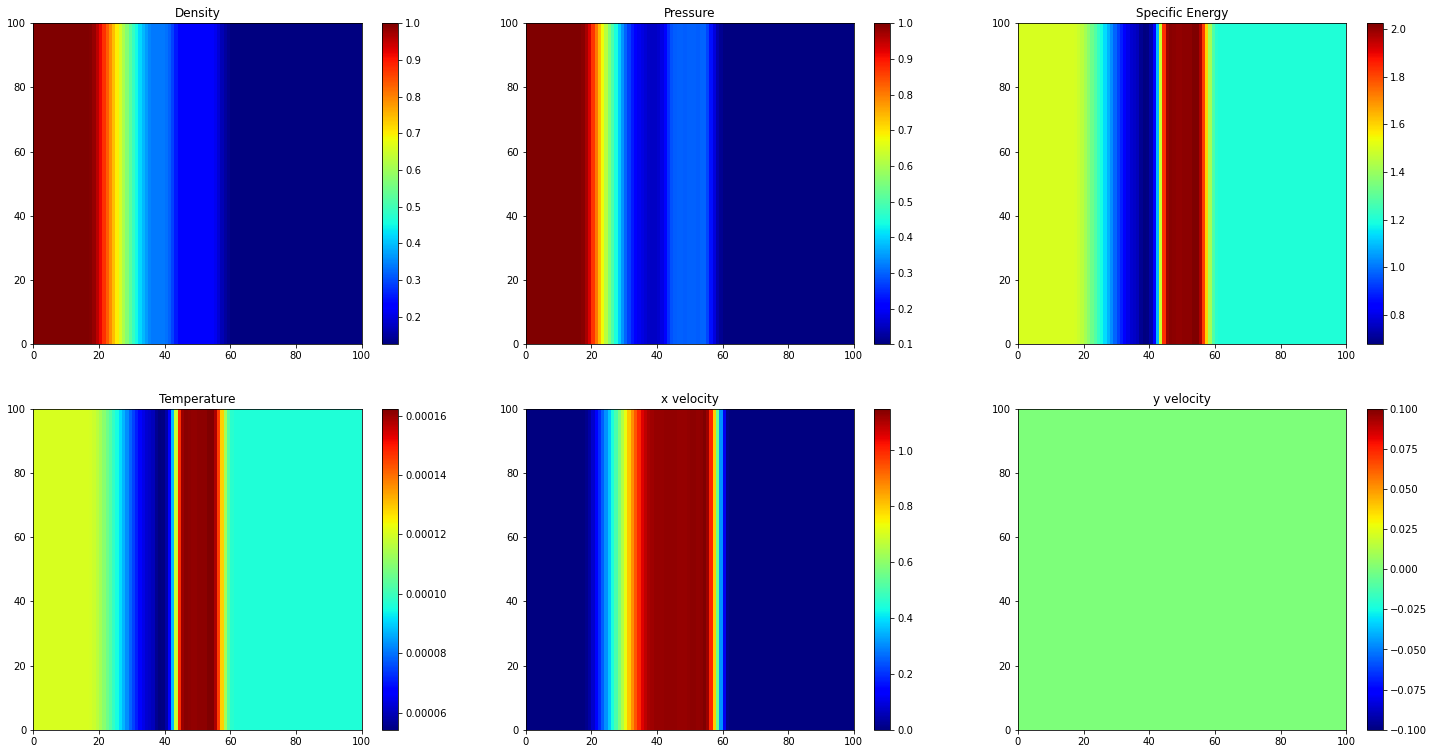

In [58]:
# setup the grid
setup_grid()

fill_ICs(type="1d shock") #1+1d shock
tmax = 200
#evolution_2d(tmax)
#evolution_1d(tmax)

for i in range(tmax):    

    timestep()
#    print(dt)

    #solve_source()
    s_update_velocity()
    s_update_energy()
    s_apply_artificial_viscosity()

    #solve_advection()
    ad_obtain_avg()
    ad_update_density()
    ad_update_energy()
    ad_get_momentum()
    ad_update_momentum()
    ad_update_velocity()
    ad_update_temperature()
    

    rad_transport()

colormaps()

<Figure size 1800x936 with 0 Axes>

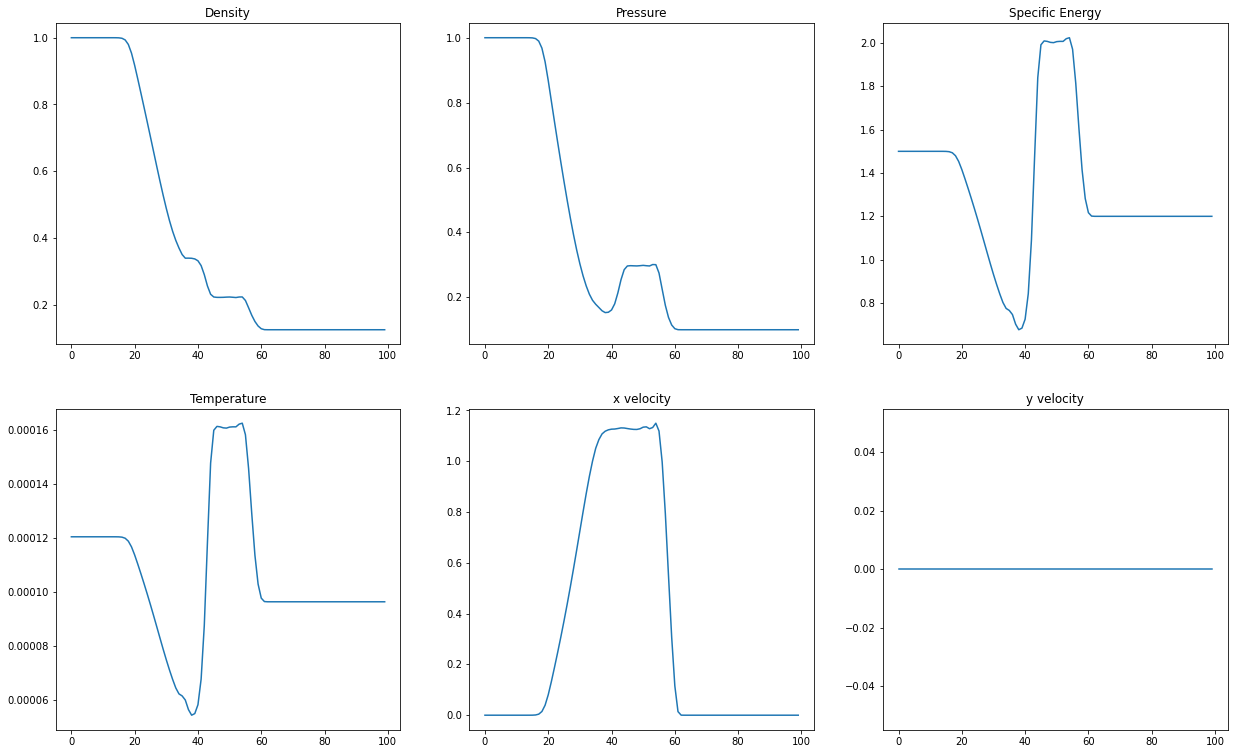

In [59]:
total_plots()

/var/folders/3x/30r4ysj529q8y2tqtkxxfj140000gp/T/ipykernel_35623/2080355556.py:21: RuntimeWarning: divide by zero encountered in true_divide
  dt_3 = dx/(4.*q*q*np.abs(du)) #dy/np.abs(w)
/var/folders/3x/30r4ysj529q8y2tqtkxxfj140000gp/T/ipykernel_35623/2080355556.py:22: RuntimeWarning: divide by zero encountered in true_divide
  dt_4 = dy/(4.*q*q*np.abs(dw)) #np.min(dx/(4.q*q*np.abs(du)),dy/(4.q*q*np.abs(dw)))
/var/folders/3x/30r4ysj529q8y2tqtkxxfj140000gp/T/ipykernel_35623/3875722505.py:145: RuntimeWarning: invalid value encountered in true_divide
  avg_e_x = get_avg_x(e)/avg_rho_x
/var/folders/3x/30r4ysj529q8y2tqtkxxfj140000gp/T/ipykernel_35623/3875722505.py:148: RuntimeWarning: invalid value encountered in true_divide
  avg_e_y = get_avg_y(e)/avg_rho_y


<Figure size 1512x936 with 0 Axes>

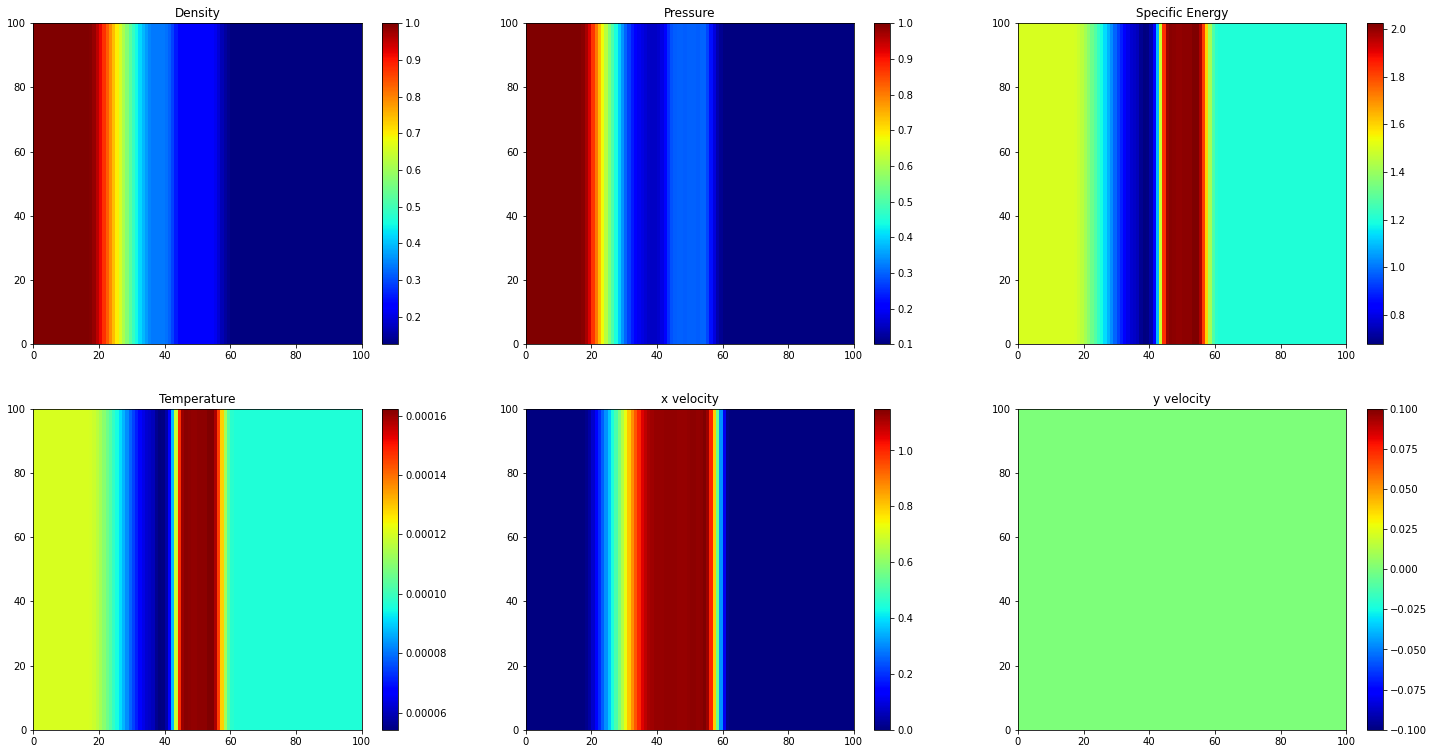

In [60]:
# setup the grid
setup_grid()

fill_ICs(type="1d shock") #1+1d shock
tmax = 200
#evolution_2d(tmax)
#evolution_1d(tmax)

for i in range(tmax):    

    timestep()
#    print(dt)

    #solve_source()
    s_update_velocity()
    s_update_energy()
    s_apply_artificial_viscosity()

    #solve_advection()
    ad_obtain_avg()
    ad_update_density()
    ad_update_energy()
    ad_get_momentum()
    ad_update_momentum()
    ad_update_velocity()
    ad_update_temperature()
    
colormaps()

<Figure size 1800x936 with 0 Axes>

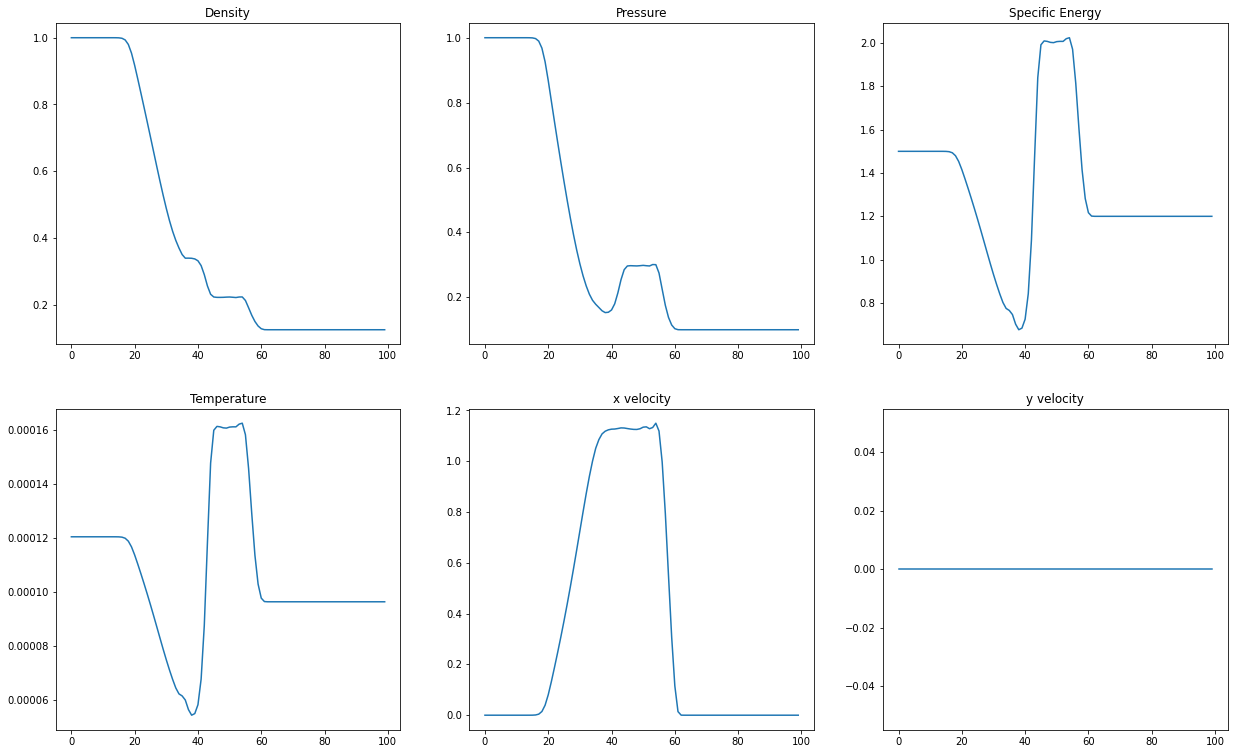

In [61]:
total_plots()